# Fraud Validation

In [45]:
#Import Data
import pandas as pd
airbnb = pd.read_csv("listings-2.csv")

#### Text Mining

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

#Consider listing name and description (which should be unique per property)
text_columns = ["name", "description"]
tfidf_matrices = {}
similarity_results = {}
sample_size = 500

#Map rows to IDs
index_to_id = airbnb["id"].to_dict()

#TF-IDF matrices for each column
for col in text_columns:
    vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
    tfidf_matrices[col] = vectorizer.fit_transform(airbnb[col].fillna(''))

#Similarity calculations with sampling
for col in text_columns:
    tfidf_matrix = tfidf_matrices[col]
    
    
    if tfidf_matrix.shape[0] > sample_size:
        tfidf_sample = tfidf_matrix[:sample_size]
    else:
        tfidf_sample = tfidf_matrix
    
    #Fit Nearest Neighbors model
    nn = NearestNeighbors(n_neighbors=10, metric="cosine").fit(tfidf_sample)
    distances, indices = nn.kneighbors(tfidf_sample)

    #Exclude self-pairs, replace indices with IDs, and filter by similarity threshold
    similarity_results[col] = [
        (index_to_id[i], index_to_id[indices[i][j]], 1 - distances[i][j]) 
        for i in range(len(distances)) 
        for j in range(1, len(indices[i])) 
        if i != indices[i][j] and (1 - distances[i][j]) > 0.8 
    ]

   
    print(f"\nTop similar pairs in column '{col}':")
    for id1, id2, score in similarity_results[col][:10]:
        print(f"ID {id1} and ID {id2}: {score}")



Top similar pairs in column 'name':
ID 162600 and ID 1371205: 0.837395166335527
ID 162600 and ID 1371229: 0.837395166335527
ID 162600 and ID 1365551: 0.837395166335527
ID 162600 and ID 1365599: 0.837395166335527
ID 162600 and ID 1339958: 0.837395166335527
ID 162600 and ID 1371261: 0.837395166335527
ID 162600 and ID 1371734: 0.8287365030934828
ID 162600 and ID 1371831: 0.8287365030934828
ID 36789 and ID 222203: 1.0
ID 177939 and ID 760196: 0.9344967608069812

Top similar pairs in column 'description':
ID 5387 and ID 1466642: 0.9536905941320121
ID 13688 and ID 543962: 0.9206445094386414
ID 168205 and ID 547635: 0.8579653471204687
ID 222203 and ID 36789: 1.0
ID 262648 and ID 1381735: 0.8014497034989557
ID 278204 and ID 1232648: 0.9244069416526766
ID 283375 and ID 271025: 1.0
ID 304658 and ID 1145716: 0.8438784106320076
ID 342158 and ID 342159: 1.0
ID 421737 and ID 964107: 0.8401788376198835


In [50]:
from collections import defaultdict

#Extract unique IDs and count how many times each ID appears in the similarity pairs
listing_counts = defaultdict(int)

#Loop over similarity results
for col, pairs in similarity_results.items():
    for id1, id2, score in pairs:
        listing_counts[id1] += 1
        listing_counts[id2] += 1

#Display the count of how many times each listing was flagged as similar
print("\nCount of how many times each listing was flagged as similar:")

#Include listing information
for listing_id, count in listing_counts.items():
    listing_info = airbnb[airbnb['id'] == listing_id].iloc[0]  #Get the first row with matching 'id'
    
    print(f"Listing ID {listing_id} was flagged {count} times.")
    print(f"Name: {listing_info['name']}")
    print(f"Description: {listing_info['description']}\n")



Count of how many times each listing was flagged as similar:
Listing ID 162600 was flagged 22 times.
Name: Waipouli Beach Resort A402 - Oceanfront Suite
Description: At the forefront of East Shore accommodation is the Waipouli Beach Resort. This World Class Resort provides luxury at your fingertips and offers opulent amenities for a variety of occasions. <br /> <br />One of Waipouli Beach Resort's top five suites, this corner penthouse includes a stately kitchen with a Wolf glass cooktop and oven, Sub-Zero refrigerator, GE profile microwave, Fisher Paykel dual dishwasher drawers, granite counter tops, African Mahogany cabinets, along with three full bathrooms

Listing ID 1371205 was flagged 22 times.
Name: Waipouli Beach Resort D304 - Ocean View Suite
Description: At the forefront of East Shore accommodation is the Waipouli Beach Resort. This World Class Resort provides luxury at your fingertips and offers opulent amenities for a variety of occasions.<br /> <br />With one of the best 

We can see from the above results that a company has listed multiple rooms within the same resort using the same listing descriptions. The only distinguishing factor is the unit number.

In [52]:
from collections import defaultdict

#Extract unique IDs and count how many times each ID appears in the similarity pairs
listing_counts = defaultdict(int)

#Loop over similarity results
for col, pairs in similarity_results.items():
    for id1, id2, score in pairs:  
        listing_counts[id1] += 1
        listing_counts[id2] += 1

#Filter the airbnb DataFrame to get only flagged listings
flagged_listing_ids = list(listing_counts.keys())


flagged_listings = airbnb[airbnb['id'].isin(flagged_listing_ids)]


columns_to_display = ['id','room_type','listing_url','host_name','name', 'description']
flagged_listings[columns_to_display]


,id,room_type,listing_url,host_name,name,description
1,5387,Entire home/apt,https://www.airbnb.com/rooms/5387,Edward,Hale Koa Studio & 1 Bedroom Units!!,This Wonderful Spacious Studio apt/flat is in ...
18,13688,Entire home/apt,https://www.airbnb.com/rooms/13688,Iliahi J.,Oceanfront Bali House w/ Hot tub @ Kehena Beach,Aloha!<br /><br /> Unwind at this authentic B...
24,162600,Entire home/apt,https://www.airbnb.com/rooms/162600,Kaua’i,Waipouli Beach Resort A402 - Oceanfront Suite,At the forefront of East Shore accommodation i...
32,15757,Entire home/apt,https://www.airbnb.com/rooms/15757,Libertad,RAINBOWS IN PARADISE,One Bedroom Garden View.<br />Local Tax per St...
42,36789,Private room,https://www.airbnb.com/rooms/36789,Michael,Ka awa Loa Plantation Guesthouse,Hawaii TA Tax #: TA-115-074-2528-01<br /><br ...
...,...,...,...,...,...,...
464,1633034,Private room,https://www.airbnb.com/rooms/1633034,Paliuli,Cozy Jacaranda Room,"Rustic, country coffee & fruit farm getaway. R..."
470,1633101,Private room,https://www.airbnb.com/rooms/1633101,Paliuli,Plumeria Room with Ocean View,"Rustic, country farm getaway. Relax on a seclu..."
474,1646411,Entire home/apt,https://www.airbnb.com/rooms/1646411,Tropical Studios At Marine Surf,🌺🌺🌺 5min to 🏄‍♀️🏊‍♀️🐠🦈🏖free 🚗🅿️💎location💎 💨WI...,!!! Hotel Zoned & %100 legal !!!<br /><br />A ...
476,1656017,Private room,https://www.airbnb.com/rooms/1656017,Rina,Mike's House- Uilani Room,Our SHARED home is a 4bd older rustic style ho...


In [53]:
#Save to CSV for inspection
output_file = "flagged_listings.csv"


flagged_listings[columns_to_display].to_csv(output_file, index=False)


Results have been exported to flagged_listings.csv


As evidenced above, many of the listings flagged by our similarity analysis appear to private rooms within the same complex, which is why the listing agent reused the listing name and description. Manual analysis of these listings does seem to support that these are individual properties.

In [48]:
#View listing descriptions for matched IDs example

airbnb[airbnb["id"].isin([806017561091754918, 930473613964233211])][["id","host_name","listing_url", "description"]]


,id,host_name,listing_url,description
23767,806017561091754918,Steven,https://www.airbnb.com/rooms/806017561091754918,Take it easy at this unique and tranquil getaway.
27256,930473613964233211,Joseph,https://www.airbnb.com/rooms/930473613964233211,Take it easy at this unique and tranquil getaway.


One of a few exceptions we found when running an earlier sample was these two properties, listed by two different hosts which have used the same pictures, descriptions, Airbnb license (which is not allowed), and only slightly different property names. This example would be classified as potentially fraudulent, at the very least because of the use of the same license.

#### Clustering

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
import numpy as np


#Drop columns with web scraping metadata and text (will handle text data separately)
columns_to_drop = [
    'listing_url', 'scrape_id', 'last_scraped', 'source', 
    'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url',
    'calendar_updated', 'calendar_last_scraped', 'bathrooms_text',"name", 
    "description", "neighborhood_overview", "host_name", "host_about", "amenities", 'license', 
    'host_neighbourhood', 'host_location', 'property_type'
]
airbnb.drop(columns=columns_to_drop, inplace=True, errors='ignore')

#Rename columns for clarification
airbnb.rename(columns={
    'neighbourhood_cleansed': 'neighborhood',
    'neighbourhood_cleansed_group': 'island'
}, inplace=True)

#Convert date columns to datetime
airbnb['host_since'] = pd.to_datetime(airbnb['host_since'], errors='coerce')
airbnb['first_review'] = pd.to_datetime(airbnb['first_review'], errors='coerce')
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'], errors='coerce')

#Extract time-based features
airbnb['host_since_month'] = airbnb['host_since'].dt.month
airbnb['host_since_day'] = airbnb['host_since'].dt.day
airbnb['host_since_weekday'] = airbnb['host_since'].dt.weekday

airbnb['first_review_year'] = airbnb['first_review'].dt.year
airbnb['last_review_year'] = airbnb['last_review'].dt.year

#Extract month from 'first_review' and 'last_review'
airbnb['first_review_month'] = airbnb['first_review'].dt.month
airbnb['last_review_month'] = airbnb['last_review'].dt.month


#Remove percentage and dollar sign symbols, then convert to floats
airbnb['host_response_rate'] = airbnb['host_response_rate'].replace({'%': ''}, regex=True).astype(float) / 100
airbnb['host_acceptance_rate'] = airbnb['host_acceptance_rate'].replace({'%': ''}, regex=True).astype(float) / 100
airbnb['price'] = airbnb['price'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

#Split text and category features
categorical_cols = airbnb.select_dtypes(include=['object']).columns.tolist()

#Numerical colummns
numerical_cols = airbnb.select_dtypes(include=['int', 'float64']).columns.tolist()

#Right-skewed columns to log scale - lots of variance and high outliers
log_scaled_cols = ['price', 'minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_minimum_nights',
'calculated_host_listings_count_private_rooms', 'maximum_nights_avg_ntm' ,
'minimum_nights_avg_ntm', 'minimum_minimum_nights', 'minimum_nights' ]

#Log scaling transformer
log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(func=np.log1p, feature_names_out='one-to-one')),
    ('scaler', RobustScaler())
])

#Remaining numerical columns
remaining_numerical_cols = [col for col in numerical_cols if col not in log_scaled_cols]

#Numerical preprocessor for non-log-scaled columns
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

#Categorical preprocessor
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, drop='first'))
])

#Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_scaled_cols),
        ('num', numerical_preprocessor, remaining_numerical_cols),
        ('cat', categorical_preprocessor, categorical_cols)
    ]
)

#Full pipeline with preprocessing
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

#Fit and transform the data
full_pipeline.fit(airbnb)
airbnb_processed = full_pipeline.transform(airbnb)


In [33]:
#PCA reduced data
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=7, random_state=42)
airbnb_reduced = pca.fit_transform(airbnb_processed)


##### Isolation Forest Model

In [34]:
#Best Model for IsoForest - Silhouette of 0.80
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

isolation_forest_ex3=IsolationForest(n_estimators=500, max_samples=0.2, contamination=0.01, random_state=42)
isolation_forest_ex3.fit(airbnb_reduced)

#Flag
airbnb['isolation_forest_anomaly'] = isolation_forest_ex3.predict(airbnb_reduced)



##### KMeans Model

In [35]:
#Best Model - Kmeans with PCA and 2 clusters (Silhouette 0.85)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


kmeans_k2 = KMeans(n_clusters=2, random_state=42)
airbnb['kmeans_cluster_k2'] = kmeans_k2.fit_predict(airbnb_reduced)

#Flag anomalies
distances_k2 = np.min(kmeans_k2.transform(airbnb_reduced), axis=1)
threshold_k2 = np.percentile(distances_k2, 95)
airbnb['kmeans_anomaly_k2'] = (distances_k2 > threshold_k2).astype(int)

##### DBSCAN Model

In [36]:
#Best Model - DBSCAN trial 2 with PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

dbscan_2 = DBSCAN(eps=7.5, min_samples=80)
airbnb['dbscan_cluster_2'] = dbscan_2.fit_predict(airbnb_reduced)

#Label
airbnb['dbscan_anomaly_2'] = (airbnb['dbscan_cluster_2'] == -1).astype(int)


#### Flagged Listings

In [37]:
#Listings flagged by all three models

all_three_flagged = airbnb[(airbnb['isolation_forest_anomaly'] == -1) & 
                           (airbnb['kmeans_anomaly_k2'] == 1) & 
                           (airbnb['dbscan_anomaly_2'] == 1)]



#Show columns
columns_to_display = ['id', 'isolation_forest_anomaly', 'kmeans_anomaly_k2', 'dbscan_anomaly_2']

#print(all_three_flagged[columns_to_display].to_string(index=False))

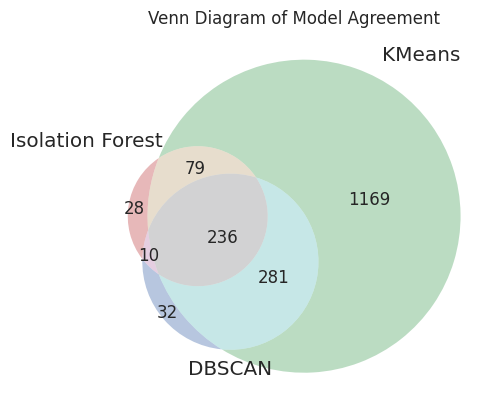

In [38]:
#%pip install matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Create Venn diagram for anomalies flagged by 3 models
set_model1 = set(airbnb[airbnb['isolation_forest_anomaly'] == -1].index)
set_model2 = set(airbnb[airbnb['kmeans_anomaly_k2'] == 1].index)
set_model3 = set(airbnb[airbnb['dbscan_anomaly_2'] == 1].index)

venn3([set_model1, set_model2, set_model3], set_labels=('Isolation Forest', 'KMeans', 'DBSCAN'))
plt.title("Venn Diagram of Model Agreement")
plt.show()

In [39]:
#Descriptive Statistics of flagged listings

#Categorical Analysis
categorical_columns = ['room_type']
for column in categorical_cols:
    print(f"\nValue counts for {column}:")
    print(all_three_flagged[column].value_counts())



Value counts for host_response_time:
host_response_time
a few days or more    97
within an hour        85
within a day          36
within a few hours    12
Name: count, dtype: int64

Value counts for host_is_superhost:
host_is_superhost
f    201
t     31
Name: count, dtype: int64

Value counts for host_verifications:
host_verifications
['email', 'phone']                  183
['phone']                            28
['email', 'phone', 'work_email']     23
['email']                             1
['phone', 'work_email']               1
Name: count, dtype: int64

Value counts for host_has_profile_pic:
host_has_profile_pic
t    221
f     15
Name: count, dtype: int64

Value counts for host_identity_verified:
host_identity_verified
t    207
f     29
Name: count, dtype: int64

Value counts for neighbourhood:
neighbourhood
Neighborhood highlights    113
Name: count, dtype: int64

Value counts for neighborhood:
neighborhood
Primary Urban Center    58
Lahaina                 29
North Kona        

Features of flagged listings which stand out:
- 1/3 of listings have hosts which take more than a few days to respond
- Large majority of hosts are not ranked as 'superhosts'
- Almost all hosts have profile pictures and a verified identity


In [46]:
#Filter listings from all_three_flagged where no profile pic and not verified
not_verified = all_three_flagged[
    (all_three_flagged['host_has_profile_pic'] == 'f') & 
    (all_three_flagged['host_identity_verified'] == 'f')
]

#Merge to get the listing_url
not_verified_with_url = not_verified.merge(airbnb[['id', 'listing_url']], on='id', how='left')


columns_to_display = ['id', 'listing_url', 'host_has_profile_pic', 'host_identity_verified', 'price', 'number_of_reviews']
print(not_verified_with_url[columns_to_display].to_string(index=False))



                 id                                      listing_url host_has_profile_pic host_identity_verified  price  number_of_reviews
 843837950423984035  https://www.airbnb.com/rooms/843837950423984035                    f                      f  350.0                  0
1075528977701419759 https://www.airbnb.com/rooms/1075528977701419759                    f                      f  233.0                  0


Of our 231 flagged listings, two had hosts which were both unverified and did not have profile pictures. Upon further inspection, both hosts had been active on the platform for less than one year and neither of their properties had any reviews.

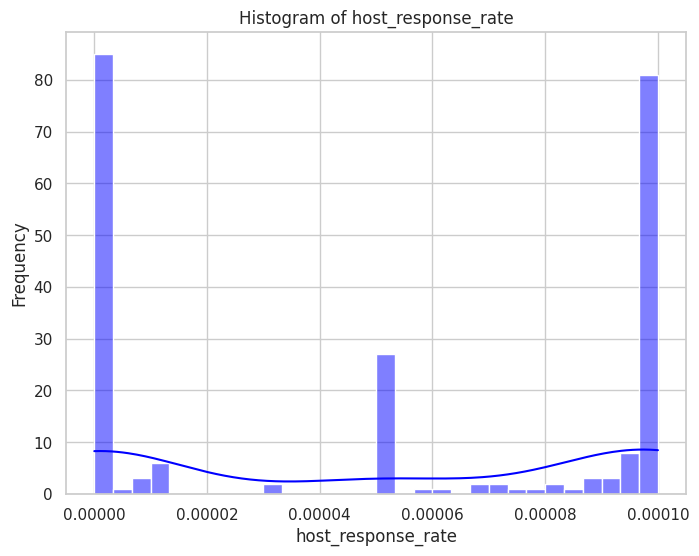

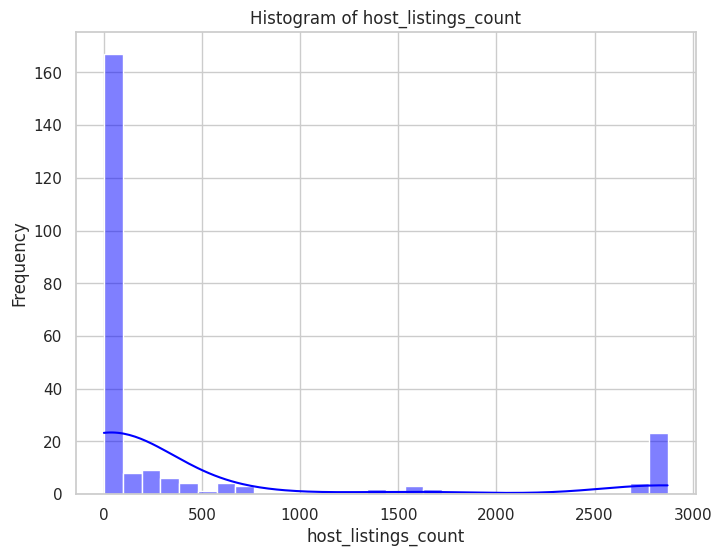

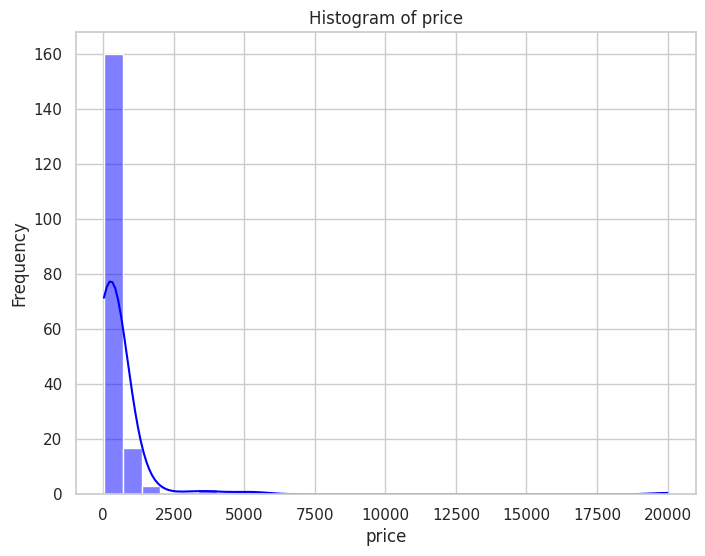

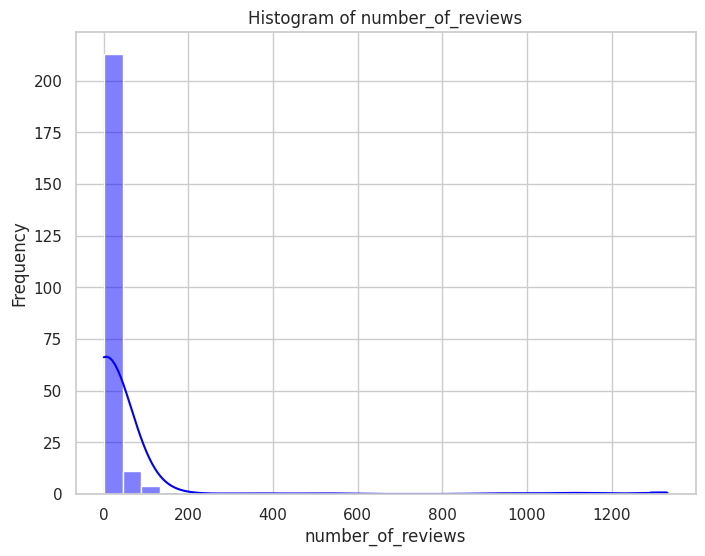

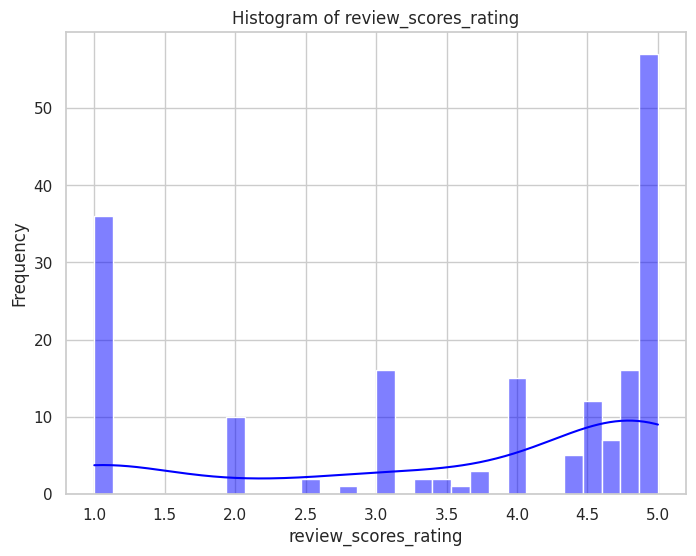

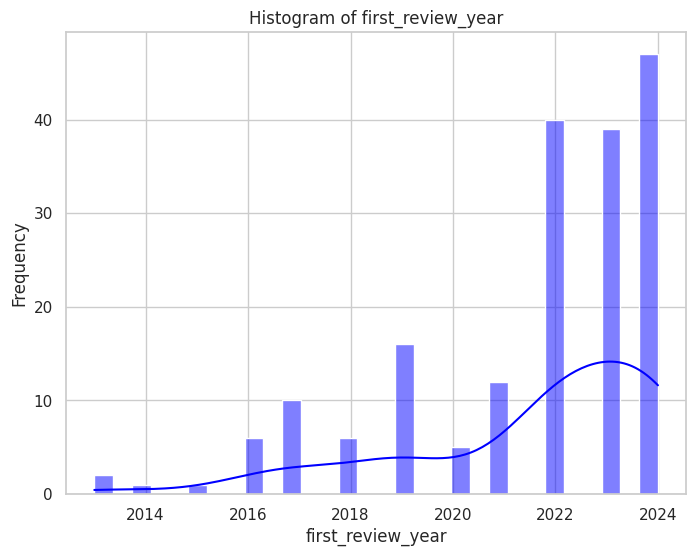

In [47]:
#Numerical analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

numerical = ['host_response_rate', 'host_listings_count', 'price', 'number_of_reviews', 'review_scores_rating','first_review_year' ]

#Create a histogram for each column
for column in numerical:
    plt.figure(figsize=(8, 6))  # Set the figure size
    sns.histplot(data=all_three_flagged, x=column, kde=True, bins=30, color="blue")  # Histogram with KDE
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Features of flagged listings which stand out:
- Host response rate varies wildly
- The majority of hosts have 1 or 2 listings, while some hosts (likely rental companies) have close to 3k
- Price is very right-skewed, with some listings charging around 20k
- Almost all listings have fewer than 50 reviews
- Reviews for these flagged properties vary considerably 
- The majority of listings had their first review between 2022-2024, suggesting they are newer listings

#### What Makes a Listing Fraudulent

According to AirBnb, they have been working through 2024 to have all hosts and listings be verified (https://www.airbnb.com/help/article/2848)

Specifically for Hawaii, hosts are required to have a TMK/TAK registration number for their properties, which we do see for many of the listings (https://www.airbnb.com/help/article/894). 

Consequently, between the results of the text mining and clustering analysis, we have given AirBnb evidence to suggest that unverified hosts and listings, listings or host with few or no reviews, and listings which lack or have a duplicate registration number should be investigated.

While not all listings with these qualities will be fraudulent, AirBnb and the state of Hawaii are moving towards stricter policies with regard to identity and property verification and stricter rules for tourism, so it is nevertheless important that AirBnb flag and notify the hosts of these listings that they are not in compliance and may be at risk of having their listing taken off the site in the future.
